# Corrective RAG (CRAG) using local LLMs

[Corrective-RAG (CRAG)](https://arxiv.org/abs/2401.15884) is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents. 

The paper follows this general flow:

* If at least one document exceeds the threshold for `relevance`, then it proceeds to generation
* If all documents fall below the `relevance` threshold or if the grader is unsure, then it uses web search to supplement retrieval
* Before generation, it performs knowledge refinement of the search or retrieved documents
* This partitions the document into `knowledge strips`
* It grades each strip, and filters out irrelevant ones

We will implement some of these ideas from scratch using [LangGraph](https://langchain-ai.github.io/langgraph/):

* If *any* documents are irrelevant, we'll supplement retrieval with web search. 
* We'll skip the knowledge refinement, but this can be added back as a node if desired. 
* We'll use [Tavily Search](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/) for web search.

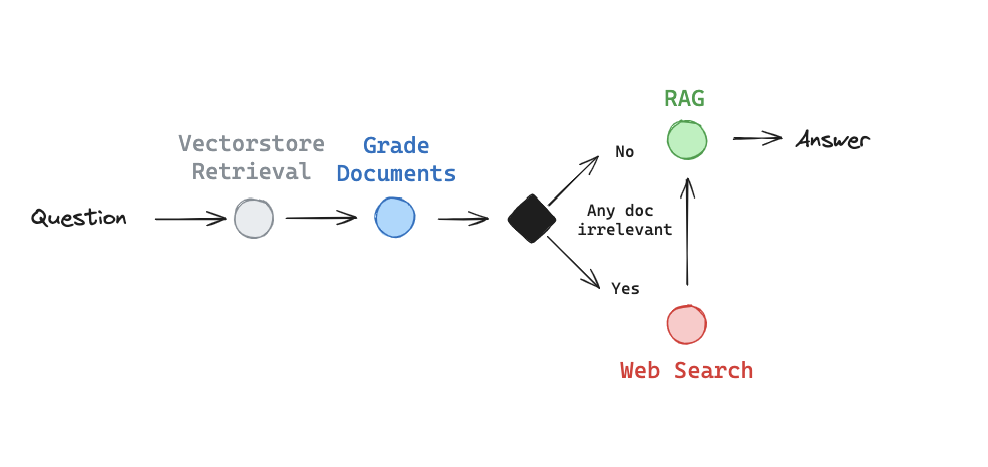

## Setup

We'll use [Ollama](https://ollama.ai/) to access a local LLM:

* Download [Ollama app](https://ollama.ai/).
* Pull your model of choice, e.g.: `ollama pull llama3`

We'll use [Tavily](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/) for web search.

We'll use a vectorstore with [Nomic local embeddings](https://blog.nomic.ai/posts/nomic-embed-text-v1) or, optionally, OpenAI embeddings.


Let's install our required packages and set our API keys:

In [1]:
# %%capture --no-stderr
# %pip install -U langchain_community tiktoken langchainhub scikit-learn langchain langgraph tavily-python  nomic[local] langchain-nomic langchain_openai

In [1]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'

In [2]:
from dotenv import load_dotenv
load_dotenv()
langsmith_api_key = os.environ.get("LANGSMITH_API_KEY")
anthropic_api_key = os.environ.get("ANTHROPIC_API_KEY")
openai_api_key = os.environ.get("OPENAI_API_KEY")
cohere_api_key = os.environ.get('COHERE_API_KEY')

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

### Ollama LLM

You can select from [Ollama LLMs](https://ollama.com/library).

In [ ]:
! ollama pull mistral:instruct

In [3]:
local_llm = "mistral:instruct"
#local_llm = "llama3"
# model_tested = "mistral:instruct"
# metadata = f"CRAG, {model_tested}"

## Create Index

Let's index 3 blog posts.

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings  # local
from langchain_openai import OpenAIEmbeddings, ChatOpenAI  # api

# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

# Embedding
embedding=NomicEmbeddings(
    model="nomic-embed-text-v1.5",
    inference_mode="local",
)

#embedding = OpenAIEmbeddings()

# Add the document chunks to the "vector store"
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=embedding,
)
retriever = vectorstore.as_retriever(k=4)

USER_AGENT environment variable not set, consider setting it to identify your requests.
Embedding texts: 100%|██████████| 187/187 [00:09<00:00, 19.30inputs/s]


In [6]:
retriever.get_relevant_documents("agent memory")

/var/folders/m0/zbb6htc128l81r3p8lhs13xm0000gn/T/ipykernel_90538/3814504427.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retriever.get_relevant_documents("agent memory")
Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 150.26inputs/s]


[Document(metadata={'id': '9560a20d-90c7-4a8b-95f8-385fc05c809a', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future step

## Define Tools

In [8]:
## Ollam JSON Mode
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_mistralai.chat_models import ChatMistralAI

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a teacher grading a quiz. You will be given: 
    1/ a QUESTION
    2/ A FACT provided by the student
    
    You are grading RELEVANCE RECALL:
    A score of yes means that ANY of the statements in the FACT are relevant to the QUESTION. 
    A score of no means that NONE of the statements in the FACT are relevant to the QUESTION. 
    1 is the highest (best) score. 0 is the lowest score you can give. 
    
    Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct. 
    
    Avoid simply stating the correct answer at the outset.
    
    Question: {question} \n
    Fact: \n\n {documents} \n\n
    
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """,
    input_variables=["question", "documents"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "documents": doc_txt}))

Embedding texts: 100%|██████████| 1/1 [00:00<00:00,  7.99inputs/s]


{'score': 'yes'}


In [9]:
### Generate

from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

# LLM
llm = ChatOllama(model=local_llm, temperature=0)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)

 The long-term memory in an LLM-powered autonomous agent system allows the agent to retain and recall infinite information over extended periods, often by leveraging an external vector store and fast retrieval. This is different from short-term memory which is restricted by the finite context window length of Transformer.


In [10]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

## Create the Graph 

Here we'll explicitly define the majority of the control flow, only using an LLM to define a single branch point following grading.

In [19]:
from typing import List
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]

In [32]:

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print(state)
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state.get("steps", [])
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}


In [52]:
# Conditional Edge
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "web_search"
    else:
        return "generate"

In [53]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)



In [54]:
# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
#workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "web_search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

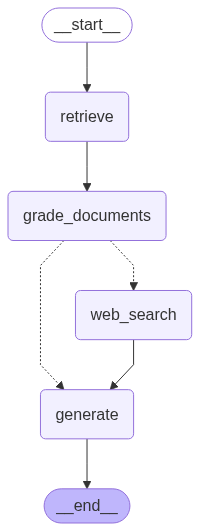

In [55]:
app

In [57]:
from pprint import pprint

# Run
inputs = {"question": "what is an agent?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

{'question': 'what is an agent?'}


Embedding texts: 100%|██████████| 1/1 [00:00<00:00,  5.28inputs/s]

"Node 'retrieve':"
'\n---\n'


"Node 'grade_documents':"
'\n---\n'
"Node 'web_search':"
'\n---\n'
"Node 'generate':"
'\n---\n'
(' An agent is a software or algorithm designed to perform tasks autonomously, '
 'often in dynamic environments. In an LLM-powered autonomous agent system, '
 'the agent functions as the brain and breaks down complex tasks into '
 'manageable subgoals, learns from past actions, and utilizes external APIs '
 'for additional information. It can also be a person or entity authorized to '
 'act on behalf of another individual or organization in various contexts such '
 'as business, law, economics, and artificial intelligence.')


In [58]:
from pprint import pprint

# Run
inputs = {"question": "agent memory"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

{'question': 'agent memory'}


Embedding texts: 100%|██████████| 1/1 [00:00<00:00,  6.09inputs/s]

"Node 'retrieve':"
'\n---\n'


"Node 'grade_documents':"
'\n---\n'
"Node 'generate':"
'\n---\n'
(' The long-term memory in an LLM-powered autonomous agent system allows the '
 'agent to retain and recall infinite information over extended periods, often '
 'by leveraging an external vector store and fast retrieval. This is different '
 'from short-term memory which is restricted by the finite context window '
 'length of Transformer.')


In [60]:
## Direct RAG 

In [61]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Agent memory consists of short-term memory for in-context learning and long-term memory for retaining and recalling information over extended periods. The long-term memory module records agents' experiences in natural language. Memory plays a crucial role in enabling agents to behave conditioned on past experiences and interact with other agents.


In [63]:
### Question Re-writer
from langchain_core.prompts import ChatPromptTemplate
# LLM
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# Prompt
system = """You are a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

print(question)
question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

agent memory


'What is the role of memory in artificial intelligence agents?'